In [46]:
# Importar las librerias del sistema
import os
import time
import shutil
import pathlib
import itertools

# Importar herramientas para tratar los datos
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import det_curve, f1_score

# Importar librerías de Machine Learning
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

#Para ocupar el modelo guardado
from tensorflow.keras.models import save_model, load_model

#Librerias para pruebas del modelo
import cv2
import requests
from io import BytesIO
from PIL import Image

# Ignorar advertencias
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [47]:
tf.config.experimental.list_physical_devices()
# tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [48]:
# Datos
data_path = '/Users/Public/CUB_200_2011/images'

In [49]:
##funciones para dar direccion y ruta a los archivos

#Devolver los marcos de datos de entrenamiento y prueba, incluida la ruta de la imagen de 2 columnas y su etiqueta
def main(train_data_path):
    for dirs in [train_data_path]:
        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))
        filepaths, labels = get_fileList(classes_list, dirs, filepaths, labels)
        train_df = obtain_train_df(filepaths, labels)

    ll1, ll2 = np.unique(labels, return_inverse=True)
    labels = np.where(np.logical_and(ll2 >= 158, ll2 <= 182), 1, 0)
    train_df['label'] = [(ii) for ii in labels]

    return train_df

#Devolver la lista de rutas de archivos, incluidas todas las rutas de imagenes comletadas y la etiqueta de cada una
def get_fileList(classes_list, dirs, filepaths, labels):
    for s_class in classes_list:
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)

        #ll1, ll2 = np.unique(labels, return_inverse=True)
        #labels = int(np.logical_or(np.logical_or(ll2==73,ll2==74),ll2==75))

    return filepaths, labels
# No denuevle nada, llena la lista de rutas de archivo con todas las rutas de imagenes y sus etiquetas
def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)

# El marco de datos de retorno con 2 columnas contiene cada ruta de imagen con su etiqueta
def obtain_train_df(filepaths, labels):
    train_df = pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df


In [50]:
data_df = main(data_path)
data_df.head(10)

,image_path,label
0,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
1,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
2,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
3,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
4,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
5,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
6,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
7,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
8,/Users/Public/CUB_200_2011/images\001.Black_fo...,0
9,/Users/Public/CUB_200_2011/images\001.Black_fo...,0


In [51]:
data_df = main(data_path)
print("Forma del dataset: ", data_df.shape)
print("_______________________________________")
print("Número de valores nulos: ")
print(data_df.isnull().sum())
print("_______________________________________")
print("Número de valores únicos: ")
print(data_df.nunique())

Forma del dataset:  (11788, 2)
_______________________________________
Número de valores nulos: 
image_path    0
label         0
dtype: int64
_______________________________________
Número de valores únicos: 
image_path    11788
label             2
dtype: int64


In [52]:
# Graficos para entender los datos mas facilmente
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)

# Sus colores
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(data_df,'label')


In [54]:
## FUNCIONES PARA LA CARGA DE DATOS EN LA LISTA Y CREAR MARCOS DE DATOS
# Generar rutas de datos con etiquetas
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    ll1, ll2 = np.unique(labels, return_inverse=True)
    

    return filepaths, [str(ii) for ii in np.logical_or(np.logical_or(ll2==73,ll2==74),ll2==75).astype(int)]

# Concatenar rutas de datos con etiquetas en un marco de datos (para su posterior ajuste en el modelo).
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Función que contiene sólo un directorio de datos y no está dividido
def tr_ts_data(tr_dir, ts_dir):
    # Entrenar y validar el dataframe
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, stratify= strat)

    # Probar el dataframe
    files, classes = define_paths(tr_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

# Función que contiene los directorios de datos de entrenamiento y prueba.
def full_data(data_dir):
    # Entrenar el dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, stratify= strat)

    # Validar y probar el dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, stratify= strat)

    return train_df, valid_df, test_df

# Función que contienen los tres directorios de datos: tren, válido y prueba.
def tr_val_ts_data(tr_dir, val_dir, ts_dir):

    # Entrenar el dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # Validar el dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # Probar el dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

# Esta funcion divide los datos en entrenados, validos y de prueba despues de convertirlos en un dataframe

def split_data(tr_dir, val_dir=None, ts_dir=None):
    # Sin datos de validación o de prueba.
    if val_dir == '' and ts_dir == '':
        train_df, valid_df, test_df = full_data(tr_dir)
        return train_df, valid_df, test_df

    # Sin datos de validación
    elif val_dir == '' and ts_dir != '':
        train_df, valid_df, test_df = tr_ts_data(tr_dir, ts_dir)
        return train_df, valid_df, test_df

    # Todos los datos existen
    elif val_dir != '' and ts_dir != '':
        train_df, valid_df, test_df = tr_val_ts_data(tr_dir, val_dir, ts_dir)
        return train_df, valid_df, test_df

In [55]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle

def create_model_data(train_df, valid_df, test_df, batch_size):
    # Define los parámetros del modelo.
    img_size = (128, 128)
    channels = 3  # RGB o escala de grises.
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Esta función, que se utilizará en el generador de datos de imagen para el aumento de datos, sólo toma la imagen y la devuelve de nuevo.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(
                                rotation_range=20,  # Rango de rotación en grados
                                width_shift_range=0.2,  # Rango de desplazamiento horizontal
                                height_shift_range=0.2, # Rango de desplazamiento vertical
                                shear_range=0.2,  # Rango de deformación de cizallamiento
                                zoom_range=0.2,  # Rango de zoom
                                horizontal_flip=True,  # Volteo horizontal aleatorio
                                vertical_flip=True  # Volteo vertical aleatorio
    )

    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Oversampling en el conjunto de entrenamiento
    ros = RandomOverSampler()
    train_df_balanced, train_labels_balanced = ros.fit_resample(train_df[['filepaths']], train_df['labels'])
    train_df_balanced['labels'] = train_labels_balanced
    train_df_balanced = shuffle(train_df_balanced)

    train_gen = tr_gen.flow_from_dataframe(train_df_balanced,
                                           x_col='filepaths',
                                           y_col='labels',
                                           target_size=img_size,
                                           class_mode='categorical',
                                           color_mode=color,
                                           shuffle=True,
                                           batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                           x_col='filepaths',
                                           y_col='labels',
                                           target_size=img_size,
                                           class_mode='categorical',
                                           color_mode=color,
                                           shuffle=True,
                                           batch_size=batch_size)

    # No aplicamos oversampling en el conjunto de prueba
    test_gen = ts_gen.flow_from_dataframe(test_df,
                                          x_col='filepaths',
                                          y_col='labels',
                                          target_size=img_size,
                                          class_mode='categorical',
                                          color_mode=color,
                                          shuffle=False,
                                          batch_size=batch_size)

    return train_gen, valid_gen, test_gen

In [56]:
## Callbacks optimizar entrenamiento del modelo.
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # Especifica cuántos epoch sin mejora antes de ajustar la tasa de aprendizaje.
        self.stop_patience = stop_patience # Especifica cuantas veces ajustar lr sin mejora para parar el entrenamiento.
        self.threshold = threshold # Especifica el umbral de precisión del entrenamiento cuando lr se ajustará en función de la pérdida de validación.
        self.factor = factor # Factor de reducción de la tasa de aprendizaje.
        self.batches = batches # Número de lotes de entrenamiento a ejecutar por epoch.
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # Guardar este valor para restaurarlo si se reinicia el entrenamiento.

        # Variables
        self.count = 0 # Cuántas veces se ha reducido la lr sin mejoras.
        self.stop_count = 0
        self.best_epoch = 1   # Epoch con menor pérdida.
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # Obtener la tasa de aprendizaje inicial y guardarla.
        self.highest_tracc = 0.0 # establecer inicialmente la mayor precisión de entrenamiento en 0.
        self.lowest_vloss = np.inf # Establecer inicialmente la pérdida de validación más baja en infinito.
        self.best_weights = self.model.get_weights() # Establecer los mejores pesos a los pesos iniciales del modelo.
        self.initial_weights = self.model.get_weights()   # Guardar los pesos iniciales por es necesario restaurarlos.

    # Definir una función que se ejecutará cuando el entrenamiento comience.
    def on_train_begin(self, logs= None):
        msg = '¿Quieres que el modelo te pida que pares el entrenamiento? [y/n]'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Acc', 'V_loss', 'V_acc', 'LR', 'Siguiente LR', 'Monitor','% Improv', 'Duración')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'el tiempo de formación transcurrido fue {str(hours)} horas, {minutes:4.1f} minutos, {seconds:4.2f} segundos)'
        print(msg)

        # Establecer los pesos del modelo en los mejores pesos.
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # Obtener precisión y pérdidas de lotes
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # Se imprime en la misma línea para mostrar el recuento de lotes en curso.
        msg = '{0:20s}Procesando el lote {1:} de {2:5s}-   precisión=  {3:5.3f}   -   pérdidas: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Definir el método que se ejecuta al final de cada epoch.
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # Obtener el ritmo de aprendizaje actual.
        current_lr = lr
        acc = logs.get('accuracy')  # Obtener precisión de entrenamiento.
        v_acc = logs.get('val_accuracy')  # Obtener precisión de validación.
        loss = logs.get('loss')  # Obtener la pérdida de entrenamiento para este epoch.
        v_loss = logs.get('val_loss')  # Obtener la pérdida de validación para este epoch.

        if acc < self.threshold: # Si la precisión del entrenamiento está por debajo del umbral ajuste lr en función de la precisión del entrenamiento.
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # Definir la mejora del progreso del modelo.

            if acc > self.highest_tracc: # La precisión del entrenamiento mejora en la época.
                self.highest_tracc = acc # Establecer la nueva precisión de entrenamiento más alta.
                self.best_weights = self.model.get_weights() # Mejora la precisión del entrenamiento, así que guarda los pesos.
                self.count = 0 # Poner el contador en 0 ya que la precisión del entrenamiento ha mejorado.
                self.stop_count = 0 # Poner el contador en 0.
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # Establece el valor del mejor epoch para este epoch.

            else:
                # La precisión del entrenamiento no ha mejorado. Comprueba si esto ha ocurrido para el número de paciencia de los epochs.
                # Si es así, ajuste el ritmo de aprendizaje.
                if self.count >= self.patience - 1: # lr debe ajustarse.
                    lr = lr * self.factor # Ajustar el aprendizaje por factor.
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # Establecer la tasa de aprendizaje en el optimizador.
                    self.count = 0 # Restablecer el conteo a 0.
                    self.stop_count = self.stop_count + 1 # Contar el número de ajustes lr consecutivos.
                    self.count = 0 # Reiniciar contador.
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # Incrementa el contador de paciencia.

        else: # La precisión del entrenamiento está por encima del umbral, así que se ajusta la tasa de aprendizaje en función de la pérdida de validación.
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # Verificar si la pérdida de validación mejoró.
                self.lowest_vloss = v_loss # Reemplazar la pérdida de validación más baja con la nueva pérdida de validación.
                self.best_weights = self.model.get_weights() # Pérdida de validación mejoró, así que guarda los pesos.
                self.count = 0 # Restablece el contador ya que mejoró la pérdida de validación.
                self.stop_count = 0
                self.best_epoch = epoch + 1 # Establecer el valor del mejor epoch a este epoch.

            else: # La pérdida de validación no mejoró.
                if self.count >= self.patience - 1: # Necesita ajustar lr.
                    lr = lr * self.factor # Ajustar la tasa de aprendizaje.
                    self.stop_count = self.stop_count + 1 # Incrementa el contador de parada porque se ajustó lr.
                    self.count = 0 # Reiniciar contador.
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # Establecer la tasa de aprendizaje en el optimizador.

                else:
                    self.count = self.count + 1 # incrementar el contador de paciencia.

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # Comprobar si la tasa de aprendizaje se ha ajustado "stop_count" veces sin mejora.
            msg = f' el entrenamiento se ha detenido en el epoch {epoch + 1} despues de {self.stop_patience} ajustes del learning rate sin mejora'
            print(msg)
            self.model.stop_training = True # Para el entrenamiento.

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'ingrese H para detener el entrenamiento o un número entero para el número de épocas a ejecutar y luego pregunte nuevamente'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'el entrenamiento se ha detenido en el epoch {epoch + 1} debido a la entrada del usuario'
                        print(msg)
                        self.model.stop_training = True # Para el entrenamiento.

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' el entrenamiento continuará hasta el epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Siguiente LR', 'Monitor', '% Improv', 'Duración')
                            print(msg)

                        except Exception:
                            print('Invalido')

In [59]:
## Funcion para graficar curvas de aceleracion y perdida

def plot_training(hist):
    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'Mejor epoch= {str(index_loss + 1)}'
    acc_label = f'Mejor epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Pérdida de entrenamiento')
    plt.plot(Epochs, val_loss, 'g', label= 'Pérdida por validación')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Entrenamiento y Pérdida por validación')
    plt.xlabel('Epochs')
    plt.ylabel('Perdidas')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Precisión del entrenamiento')
    plt.plot(Epochs, val_acc, 'g', label= 'Precisión de la validación')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Entrenamiento y Precisión de la validación')
    plt.xlabel('Epochs')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout
    plt.show()

In [60]:
## Division de los datos y creacion de los generadores

train_dir = data_path
valid_dir = input('Introduzca el directorio de datos de validación (si no hay directorio válido, pulse Enter): ')
test_dir = input('Introduzca el directorio de datos de prueba (si no hay directorio de prueba, pulse Enter): ')

# Obtener datos divididos.
train_df, valid_df, test_df = split_data(train_dir, valid_dir, test_dir)

# Obtener generadores.
batch_size = 8


train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

Found 18576 validated image filenames belonging to 2 classes.
Found 1179 validated image filenames belonging to 2 classes.
Found 1179 validated image filenames belonging to 2 classes.


In [61]:
# Obtener el número de clases
num_classes = len(data_df['label'].unique())

# Crear estructura de modelo.
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # Para definir el número de clases en la capa densa.

# Crear el modelo CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

# Crear un modelo preentrenado (puede crear un modelo preentrenado como: EfficientNet, VGG, ResNet).
# Usaremos EfficientNetB1 de la familia EfficientNet.
#base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Crear el modelo
#efficientNet_model = Sequential([
#    base_model,
#    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
#    Dense(256, activation='relu'),
#    Dropout(rate=0.45, seed=123),
#    Dense(class_count, activation='softmax')
#])

#efficientNet_model.compile(optimizer=Adamax(learning_rate=0.001),
#                          loss='categorical_crossentropy',  # Utilizar 'categorical_crossentropy' para múltiples clases
#                         metrics=['accuracy'])

#efficientNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)     

In [62]:
## GPU CUDA
# Verifica si estás utilizando una GPU
if tf.test.gpu_device_name():
    print('GPU found')
    # Imprime información adicional sobre la GPU
    gpu_info = !nvidia-smi
    print(gpu_info)
else:
    print('GPU not found')

GPU found
['Sat Sep  9 18:04:57 2023       ', '+---------------------------------------------------------------------------------------+', '| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |', '|-----------------------------------------+----------------------+----------------------+', '| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |', '| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |', '|                                         |                      |               MIG M. |', '|=========================================+======================+======================|', '|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |', '|  0%   35C    P0              N/A /  95W |   3719MiB /  4096MiB |      8%      Default |', '|                                         |                      |                  N/A |', '+----------------------

In [76]:
batch_size = 8  # Establecer el tamaño del lote para el entrenamiento.
epochs = 25   # Número de todos los epoch en entrenamiento.
patience = 1   # Número de epochs a esperar para ajustar lr si el valor monitoreado no mejora.
stop_patience = 3   # Número de epochs a esperar antes de detener el entrenamiento si el valor monitoreado no mejora.
threshold = 0.9   # Si la precisión del tren es < umbral, ajuste la precisión del monitor; de lo contrario, monitoree la pérdida de validación.
factor = 0.5   # Factor para reducir lr.
ask_epoch = 5   # Número de epochs a ejecutar antes de preguntar si desea detener el entrenamiento.
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # Número de lotes de entrenamiento para ejecutar por epoch.

callbacks = [MyCallback(model= cnn_model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [77]:
#Entrenando el modelo
history = cnn_model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                                validation_data= valid_gen, validation_steps= None, shuffle= False)

¿Quieres que el modelo te pida que pares el entrenamiento? [y/n]
 Epoch     Loss      Acc    V_loss    V_acc     LR    Siguiente LR Monitor  % Improv  Duración
 1 /25     0.214   90.999   2.09623  91.094   0.00003  0.00003  val_loss     0.00    152.36 0.21414 
 2 /25     0.211   91.231   2.37393  92.027   0.00003  0.00002  val_loss    -13.25   163.79 0.21145 
 3 /25     0.200   91.607   2.38603  92.197   0.00002  0.00001  val_loss    -13.82   167.64 0.20019 
 4 /25     0.203   91.457   2.45820  91.942   0.00001  0.00000  val_loss    -17.27   197.53 0.20340 
 el entrenamiento se ha detenido en el epoch 4 despues de 3 ajustes del learning rate sin mejora
el tiempo de formación transcurrido fue 0.0 horas, 11.0 minutos, 21.50 segundos)


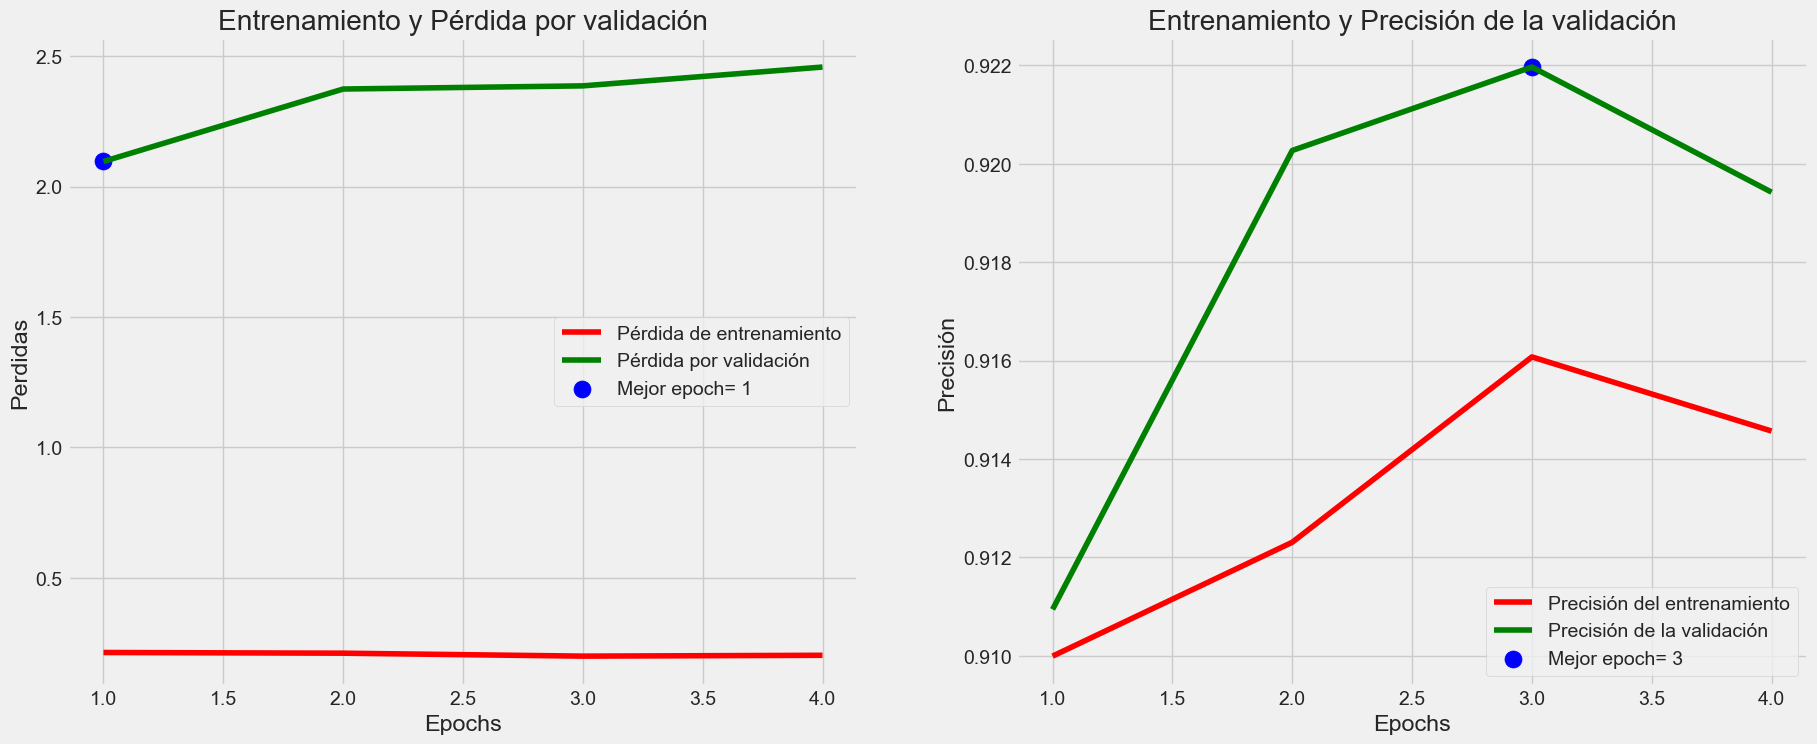

In [78]:
## Llamada de los graficos de entrenamiento  vs la validacion y entrenamiento vs la perdida de la validacion
plot_training(history)

In [80]:
# Guardar el modelo entrenado
model_save_path = 'cnn_model.h5'
cnn_model.save(model_save_path)
print("Modelo guardado en:", model_save_path)

Modelo guardado en: cnn_model.h5


In [81]:
# Cargar el modelo desde el archivo guardado
cnn_model = load_model(model_save_path)

In [82]:
## Puntuacion en conjuntos de datos validos y de prueba
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = cnn_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = cnn_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = cnn_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Pérdida del entrenamiento: ", train_score[0])
print("Precisión del entrenamiento: ", train_score[1])
print('-' * 20)
print("Pérdida de la validación: ", valid_score[0])
print("Precisión de la validación: ", valid_score[1])
print('-' * 20)
print("Pérdida de las pruebas: ", test_score[0])
print("Precisión de las pruebas: ", test_score[1])

131/131 [==============================] - 5s 41ms/step - loss: 0.2601 - accuracy: 0.9246
Pérdida del entrenamiento:  0.23795266449451447
Precisión del entrenamiento:  0.8969465494155884
--------------------
Pérdida de la validación:  1.724273920059204
Precisión de la validación:  0.9064885377883911
--------------------
Pérdida de las pruebas:  0.26007983088493347
Precisión de las pruebas:  0.9246183037757874


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x00000000351CAFB0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x00000000351CAFB0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
148/148 [==============================] - 5s 34ms/step


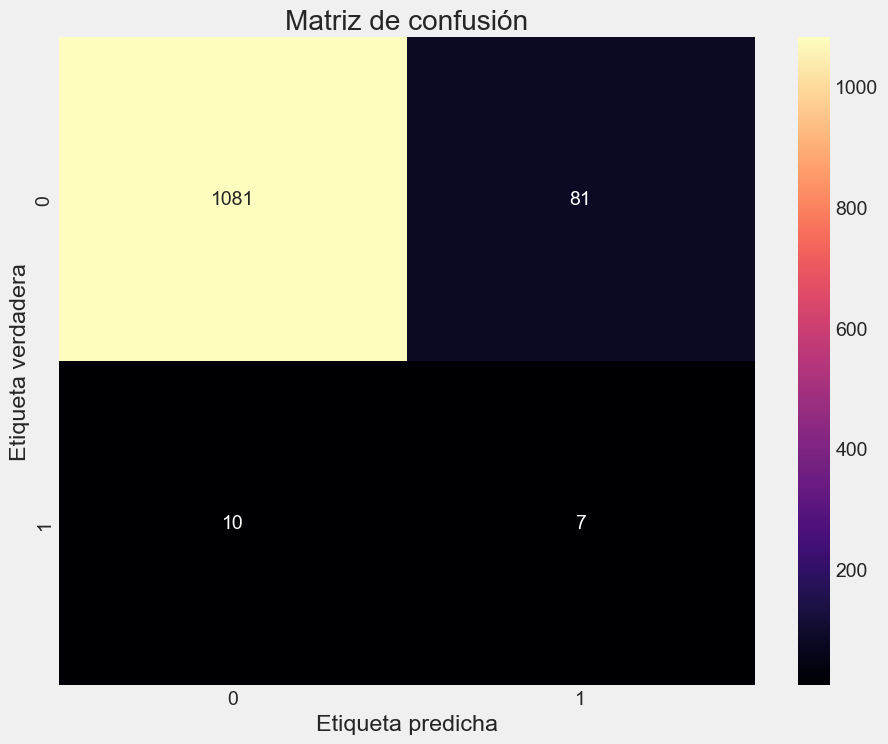

In [83]:
## Mastriz de confusion
y_pred = cnn_model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

#------------------------------------------------------------------------------------------------#

class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="magma", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de confusión")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta verdadera")
plt.show()

In [84]:
## Informe de clasificacion

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Informe de clasificación.
print(classification_report(y_true_labels, y_pred_labels, target_names= classes))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1162
           1       0.08      0.41      0.13        17

    accuracy                           0.92      1179
   macro avg       0.54      0.67      0.55      1179
weighted avg       0.98      0.92      0.95      1179



In [90]:
# Aquí debes importar y cargar el modelo EfficientNet
# Asegúrate de tener instalada la biblioteca necesaria y de haber cargado el modelo correctamente

def load_image_from_file(file_path):
    img = cv2.imread(file_path)
    if img is None:
        raise Exception("La imagen no se pudo cargar.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    return img

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((128, 128))
    img = np.array(img)
    return img

def predict_image(image):
    image = np.expand_dims(image, axis=0)
    if image.size == 0:
        raise Exception("La imagen no se pudo cargar.")
    predictions = cnn_model.predict(image)
    class_idx = np.argmax(predictions[0])
    class_name = list(test_gen.class_indices.keys())[class_idx]
    confidence = predictions[0][class_idx]
    return class_name, confidence

try:
    # Obtener la imagen del usuario (ya sea desde un archivo o una URL)
    image_source = input("Ingrese la ruta de la imagen (archivo o URL): ")
    if image_source.lower().startswith("http"):
        image = load_image_from_url(image_source)
    else:
        image = load_image_from_file(image_source)

    # Mostrar la imagen
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Realizar la predicción
    class_name, confidence = predict_image(image)

    # Verificar si es una curraca o no
    if class_name == "0":
        print("La imagen contiene una Curruca.")
        print("Confianza:", confidence)
    elif class_name == "1":
        print("La imagen no contiene una Curruca.")
        print("Confianza:", confidence)

except Exception as e:
    print("Se produjo un error:", str(e))


Se produjo un error: La imagen no se pudo cargar.
